In [1]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# List of model names to evaluate
model_names = ["CounTX", "CLIP-Count", "VLCounter", "TFPOC", "DAVE"]
split = "test"  # val not working actually
root = Path(".")
gt_json = "data/FSC147/gt_cnts_FSC147.json"
img_class_txt_path = "data/FSC147/ImageClasses_FSC147.txt"

# Load Image Class .txt
img_class = {}
with open(img_class_txt_path, 'r') as file:
    for line in file:
        line = line.strip().split('\t')
        if len(line) == 2:
            img_name, label = line
            # img_id = img_name.split(".")[0]
            img_class[img_name] = label

# Load GT Counts JSON
with open(gt_json, 'r') as file:
    gt_counts_dict = json.load(file)

In [4]:
columns = pd.read_csv(root / 'benchmark_results' / 'CLIP-Count' / f"Inference_Test2_Upper_CLIP-Count_test.csv")
gt_counts = list(gt_counts_dict.values())
gt_df = pd.DataFrame(index=range(len(gt_counts)), columns=columns)
for i, value in enumerate(gt_counts):
    gt_df.iloc[i, :] = value

# Loop through the model names
dfs = []
for model_name in model_names:
    if model_name == "DAVE":
        df_test1 = pd.read_csv(root / 'benchmark_results' / 'DAVE_mod_thr_0.10' / f"Inference_Test1_{model_name}_{split}.csv", index_col=0)
    else:
        df_test1 = pd.read_csv(root / 'benchmark_results' / model_name / f"Inference_Test1_{model_name}_{split}.csv", index_col=0)
    correct_df = pd.DataFrame(index=df_test1.index, columns=["correct_count"])
    for k in df_test1.index:
        v = img_class[k]
        correct_df.loc[k, "correct_count"] = df_test1.loc[k, v]
    correct_df.index.name = "img_name"
    
    if model_name == "DAVE":
        df_test2 = pd.read_csv(root / 'benchmark_results' / 'DAVE_mod_thr_0.10' / f"Inference_Test2_Upper_{model_name}_{split}.csv")
    else:
        df_test2 = pd.read_csv(root / 'benchmark_results' / model_name / f"Inference_Test2_Upper_{model_name}_{split}.csv")
    df_test2.rename(columns={"Unnamed: 0": "img_name"}, inplace=True)
    # convert columns to rows
    df_test2 = df_test2.melt(id_vars=["img_name"], var_name="class", value_name="count")
    df_test2.set_index("img_name", inplace=True)
    df_test2['model'] = model_name
    df_merged = df_test2.merge(correct_df, on="img_name")
    df_merged.reset_index(inplace=True)
    dfs.append(df_merged)

# Combine all the dataframes
df_orig = pd.concat(dfs, ignore_index=True)

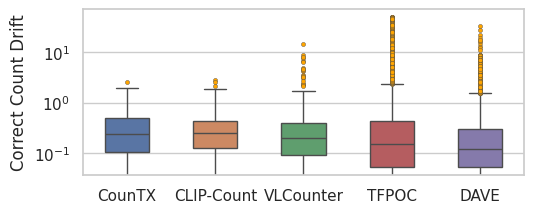

In [6]:
df = df_orig.copy()
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(5.5, 2.3))

# if negative, set correct_count to 0
df["correct_count"] = df["correct_count"].apply(lambda x: 0 if x < 0 else x)

df["shift_wrt_correct"] = (df["count"] - df["correct_count"]).abs() / df["correct_count"]
df = df[df["shift_wrt_correct"] < 50]

sns.boxplot(data=df, x="model", y="shift_wrt_correct", hue="model", ax=ax, whis=5, width=0.5, flierprops=dict(marker='o', markersize=3, markerfacecolor='orange', markeredgewidth=0.3))
# ax.set_ylim(0.005, 50)
ax.set_yscale("log")
# sns.barplot(data=df, x="model", hue="model", y="shift_wrt_correct", errorbar=('ci', 99), width=0.5, ax=ax)
ax.set_ylabel("Correct Count Drift")
# remove x-axis label without occupying space
ax.set_xlabel("")

plt.tight_layout()
plt.savefig("correct_count_shift.pdf")

(0.0, 60.0)

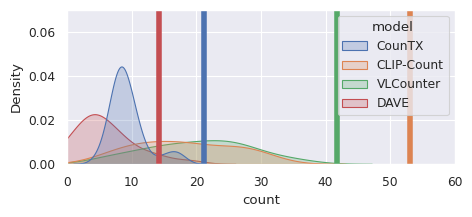

In [11]:
df = df_orig.copy()

# filter one image
df = df[df["img_name"] == "999.jpg"]

fig, ax = plt.subplots(figsize=(5, 2))

# sns.histplot(data=df, x="count", hue="model", bins=60, kde=True)
sns.kdeplot(data=df, x="count", hue="model", fill=True, common_norm=True, ax=ax)

correct_count = df[["model", "correct_count"]].drop_duplicates()
# get list of correct counts
correct_count = correct_count["correct_count"].values

# get color palette from legend
palette = sns.color_palette()

ax.vlines(x=correct_count, ymin=0, ymax=0.07, colors=palette, linewidths=4)

# correct_count["y"] = 0.07
# sns.barplot(data=correct_count, x="correct_count", y="y", hue="model", ax=ax, alpha=0.5, width=1)

# colors of the vlines follow the colors of the models
# sns.barplot(data=correct_count, x="model", y="correct_count", ax=ax, color="black")

ax.set_ylim(0, 0.07)
ax.set_xlim(0, 60)